In [ ]:
!jupyter nbconvert --to script *.ipynb

In [1]:
import os
import pickle
import gc
import pandas as pd
pd.set_option('display.max_columns', 1000)
import numpy as np
from tqdm import tqdm_notebook, tnrange, tqdm
from utils import (reduce_mem_usage, load_pickle, dump_pickle, get_nominal_dfal, feats_root,
                   ordinal_cate_cols, nominal_cate_cols, identity_cols,
                   fit_cat, fit_lgb, verbose_feature_importance_cat)

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import Imputer
import h5py

In [2]:
from _2_1_gen_user_features import (
    add_user_click_stats, add_user_da_feature_click, add_user_ho_feature_click,
    add_user_total_da_click)
from _2_2_gen_item_features import (
    add_item_click_stats, add_item_da_feature_click, add_item_ho_feature_click,
    add_item_total_da_click)
from _2_3_gen_shop_features import (
    add_shop_click_stats, add_shop_da_feature_click, add_shop_ho_feature_click,
    add_shop_total_da_click)
from _2_4_gen_acc_sum_counts import add_global_count_sum
from _2_5_gen_smooth_cvr import add_hist_cvr_smooth
from _2_6_gen_bagging_features import add_target_features
from _2_7_gen_level_features import add_level_features

In [5]:
def gen_dataset(data, dump_file, scope='tr', last_da=24, updata=False):
    if os.path.exists(dump_file) and not updata:
        print('Found ' + dump_file)
        store = pd.HDFStore(dump_file, mode='r',complevel=9,)
        data = store['dataset']
        store.close()
    else:
        print('Generating {} Dataset...'.format(scope))
        ##################################################################
        # add user click
        data = add_user_click_stats(data)
        data = add_user_total_da_click(data)
        data = add_user_da_feature_click(data)
        data = add_user_ho_feature_click(data)
        # add item click
        data = add_item_click_stats(data)
        data = add_item_total_da_click(data)
        data = add_item_da_feature_click(data)
        data = add_item_ho_feature_click(data)
        # add shop click
        data = add_shop_click_stats(data)
        data = add_shop_total_da_click(data)
        data = add_shop_da_feature_click(data)
        data = add_shop_ho_feature_click(data)
        # add global count sum
        data = add_global_count_sum(data, last_da)

        # add smooth cvr
        for c in tqdm(identity_cols, desc='add_hist_cvr_smooth'):
            data = add_hist_cvr_smooth(data, c)
        print('add_hist_cvr_smooth completed')
        
        for c in tqdm(['item_id', 'shop_id', 'user_id', 'item_brand_id', 'item_city_id'], desc='add_target_features'):
            data = add_target_features(data, c)
        print('add_target_features completed')
        
        for c in tqdm(['item_id', 'shop_id', 'user_id'], desc='add_level_features'):
            data = add_level_features(data, c)
        
        drop_cols = []
        for c in data.columns:
            if c.startswith('agg_level_item_id_shop_'):
                drop_cols.append(c)
        data = data.drop(drop_cols, axis=1)
        print('add_level_features completed')
        
        if scope == 'te':
            data.drop('is_trade', axis=1, inplace=True)
            
        nan_cols = []
        for c in data.columns:
            nan_count = data[data[c].isnull()].shape[0]
            if nan_count>0:
                print(c, nan_count)
                nan_cols.append(c)
        data[nan_cols] = Imputer(strategy='median').fit_transform(data[nan_cols])
        print(data.shape)
        
        
        store = pd.HDFStore(dump_file, mode='w',complevel=9)
        store['dataset'] = data
        store.close()
        print('Generated {} Dataset'.format(scope))
    
    
    return data


In [6]:
def gen_final_dataset(tr_start_da, tr_end_da, te_da=24, updata=False):
    dfal = get_nominal_dfal()
    dfal = dfal.sort_values('dt')
    user_time_delta_feature = load_pickle('./feats/user_time_delta_feature.pkl')
    user_last_attrs_feature = load_pickle('./feats/user_last_attrs_feature.pkl')
    dfal = pd.concat([dfal, user_time_delta_feature, user_last_attrs_feature], axis=1)
    print(dfal.shape)
    
    dftr = dfal.loc[(dfal.da >= tr_start_da) & (dfal.da <= tr_end_da)]
    tr_dump_file = './cache/final_dataset_tr_{}_{}.h5'.format(tr_start_da, tr_end_da)
    dftr = gen_dataset(dftr,tr_dump_file, 'tr', tr_end_da, updata)
    
    dfte = dfal.loc[dfal.da == te_da]
    te_dump_file = './cache/final_dataset_te_{}.h5'.format(te_da)
    dfte = gen_dataset(dfte,te_dump_file, 'te', te_da, updata)
    
    del dfal
    gc.collect()
    return dftr, dfte

In [7]:
ignore_cols = ['instance_id', 'dt', 'da', 'user_id', 'item_id', 'shop_id']

def get_dataset(updata=False):

    dftr, dfte = gen_final_dataset(19, 23, 24, updata)
    trset = dftr.loc[(dftr.da > 18) & (dftr.da <= 22), :].drop(ignore_cols, axis=1)
    vaset = dftr.loc[dftr.da == 23, :].drop(ignore_cols, axis=1)
    teset = dfte.loc[dfte.da == 24, :].drop(ignore_cols, axis=1)

    del dftr
    del dfte
    gc.collect()

    X_tr = trset.drop('is_trade', axis=1)
    X_va = vaset.drop('is_trade', axis=1)
    X_te = teset
    y_tr = trset.is_trade
    y_va = vaset.is_trade

    del trset
    del vaset
    del teset
    gc.collect()
    return X_tr, y_tr, X_va, y_va, X_te

In [8]:
X_tr, y_tr, X_va, y_va, X_te =  get_dataset(True)

(521026, 66)
Generating tr Dataset...
add_user_click_stats completed.


adding user_item_id_click_da.pkl:   0%|          | 0/12 [00:00<?, ?it/s]

add_user_total_da_click completed.


adding user_item_id_click_ho.pkl:   0%|          | 0/12 [00:00<?, ?it/s]

add_user_da_feature_click completed.


adding user_shop_star_level_click_ho.pkl: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]      


add_user_ho_feature_click completed.
add_item_click_stats completed.


adding item_shop_id_click_da.pkl:   0%|          | 0/9 [00:00<?, ?it/s]

add_item_total_da_click completed.


adding item_shop_id_click_ho.pkl:   0%|          | 0/9 [00:00<?, ?it/s]

add_item_da_feature_click completed.


adding item_shop_star_level_click_ho.pkl: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]      


add_item_ho_feature_click completed.
add_shop_click_stats completed.


adding shop_item_category_list_click_da.pkl:   0%|          | 0/14 [00:00<?, ?it/s]

add_shop_total_da_click completed.


adding shop_item_category_list_click_ho.pkl:   0%|          | 0/14 [00:00<?, ?it/s]

add_shop_da_feature_click completed.


  0%|          | 0/5 [00:00<?, ?it/s]

add_shop_ho_feature_click completed.


adding hist cvr smooth shop_id,23: 100%|██████████| 5/5 [00:00<00:00, 97.11it/s]

add_hist_cvr_smooth item_id completed


adding hist cvr smooth user_id,23: 100%|██████████| 5/5 [00:00<00:00, 88.44it/s]

add_hist_cvr_smooth shop_id completed


add_target_features:   0%|          | 0/5 [00:00<?, ?it/s]

add_hist_cvr_smooth user_id completed
add_hist_cvr_smooth completed


add_level_features:   0%|          | 0/3 [00:00<?, ?it/s]

add_target_features completed


add_level_features: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]


add_level_features completed
agg_last_item_category_list 128867
agg_last_item_brand_id 128867
agg_last_item_city_id 128867
agg_last_item_price_level 128867
agg_last_item_sales_level 128867
agg_last_item_collected_level 128867
agg_last_item_pv_level 128867
agg_last_context_page_id 128867
agg_last_shop_review_num_level 128867
agg_last_shop_star_level 128867
agg_last_shop_review_positive_rate 128867
agg_last_shop_score_delivery 128867
agg_last_shop_score_description 128867
agg_last_shop_score_service 128867
agg_diff_item_price_level 128867
agg_diff_item_sales_level 128867
agg_diff_item_collected_level 128867
agg_diff_item_pv_level 128867
agg_diff_shop_review_num_level 128867
agg_diff_shop_star_level 128867
agg_diff_shop_review_positive_rate 128867
agg_diff_shop_score_delivery 128867
agg_diff_shop_score_description 128867
agg_diff_shop_score_service 128867
agg_item_id_sum_count 842
agg_shop_id_sum_count 273
agg_user_id_sum_count 41708
agg_item_brand_id_sum_count 155
item_id_cvr 4662
shop_i

adding user_item_id_click_da.pkl:   0%|          | 0/12 [00:00<?, ?it/s]

add_user_click_stats completed.
add_user_total_da_click completed.


adding user_item_id_click_ho.pkl:   0%|          | 0/12 [00:00<?, ?it/s]

add_user_da_feature_click completed.


adding user_shop_star_level_click_ho.pkl: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]      


add_user_ho_feature_click completed.
add_item_click_stats completed.


adding item_user_id_click_da.pkl:  11%|█         | 1/9 [00:00<00:01,  6.36it/s]

add_item_total_da_click completed.


adding item_shop_id_click_ho.pkl:  11%|█         | 1/9 [00:00<00:01,  5.64it/s]

add_item_da_feature_click completed.


adding item_shop_star_level_click_ho.pkl: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]      


add_item_ho_feature_click completed.
add_shop_click_stats completed.


adding shop_item_brand_id_click_da.pkl:   7%|▋         | 1/14 [00:00<00:02,  6.08it/s]     

add_shop_total_da_click completed.


adding shop_item_category_list_click_ho.pkl:   7%|▋         | 1/14 [00:00<00:02,  5.30it/s]

add_shop_da_feature_click completed.


 20%|██        | 1/5 [00:00<00:00,  7.56it/s]

add_shop_ho_feature_click completed.


adding hist cvr smooth user_id,24: 100%|██████████| 1/1 [00:00<00:00, 121.96it/s]

add_hist_cvr_smooth item_id completed
add_hist_cvr_smooth shop_id completed


add_target_features:  20%|██        | 1/5 [00:00<00:00,  5.91it/s]

add_hist_cvr_smooth user_id completed
add_hist_cvr_smooth completed


add_level_features:   0%|          | 0/3 [00:00<?, ?it/s]

add_target_features completed


add_level_features: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


add_level_features completed
agg_last_item_category_list 17999
agg_last_item_brand_id 17999
agg_last_item_city_id 17999
agg_last_item_price_level 17999
agg_last_item_sales_level 17999
agg_last_item_collected_level 17999
agg_last_item_pv_level 17999
agg_last_context_page_id 17999
agg_last_shop_review_num_level 17999
agg_last_shop_star_level 17999
agg_last_shop_review_positive_rate 17999
agg_last_shop_score_delivery 17999
agg_last_shop_score_description 17999
agg_last_shop_score_service 17999
agg_diff_item_price_level 17999
agg_diff_item_sales_level 17999
agg_diff_item_collected_level 17999
agg_diff_item_pv_level 17999
agg_diff_shop_review_num_level 17999
agg_diff_shop_star_level 17999
agg_diff_shop_review_positive_rate 17999
agg_diff_shop_score_delivery 17999
agg_diff_shop_score_description 17999
agg_diff_shop_score_service 17999
agg_item_id_sum_count 555
agg_shop_id_sum_count 143
agg_user_id_sum_count 30962
agg_item_brand_id_sum_count 57
agg_item_city_id_sum_count 3
item_id_cvr 555
sho

In [9]:
X_tr.shape,y_tr.shape, X_va.shape, y_va.shape, X_te.shape

((271518, 722), (271518,), (57421, 722), (57421,), (42888, 722))

In [10]:
cates_cols = [
    'item_category_list', 'item_city_id', 'user_gender_id',
    'user_occupation_id', 'item_brand_id'
]

cates_cols = cates_cols +  list(filter(lambda x : 'user' not in x, ['agg_last_'+ c for c in cates_cols]))

cates_cols

['item_category_list',
 'item_city_id',
 'user_gender_id',
 'user_occupation_id',
 'item_brand_id',
 'agg_last_item_category_list',
 'agg_last_item_city_id',
 'agg_last_item_brand_id']

Training until validation scores don't improve for 125 rounds.
[50]	train's binary_logloss: 0.385298	valid's binary_logloss: 0.384132
[100]	train's binary_logloss: 0.241778	valid's binary_logloss: 0.240133
[150]	train's binary_logloss: 0.167145	valid's binary_logloss: 0.165551
[200]	train's binary_logloss: 0.126461	valid's binary_logloss: 0.125518
[250]	train's binary_logloss: 0.103616	valid's binary_logloss: 0.104023
[300]	train's binary_logloss: 0.0902026	valid's binary_logloss: 0.0927008
[350]	train's binary_logloss: 0.0818588	valid's binary_logloss: 0.0868768
[400]	train's binary_logloss: 0.0761732	valid's binary_logloss: 0.0839415
[450]	train's binary_logloss: 0.0720276	valid's binary_logloss: 0.0825899
[500]	train's binary_logloss: 0.0685739	valid's binary_logloss: 0.0819728
[550]	train's binary_logloss: 0.0656346	valid's binary_logloss: 0.0817509
[600]	train's binary_logloss: 0.0632036	valid's binary_logloss: 0.0817598
[650]	train's binary_logloss: 0.0610983	valid's binary_loglo

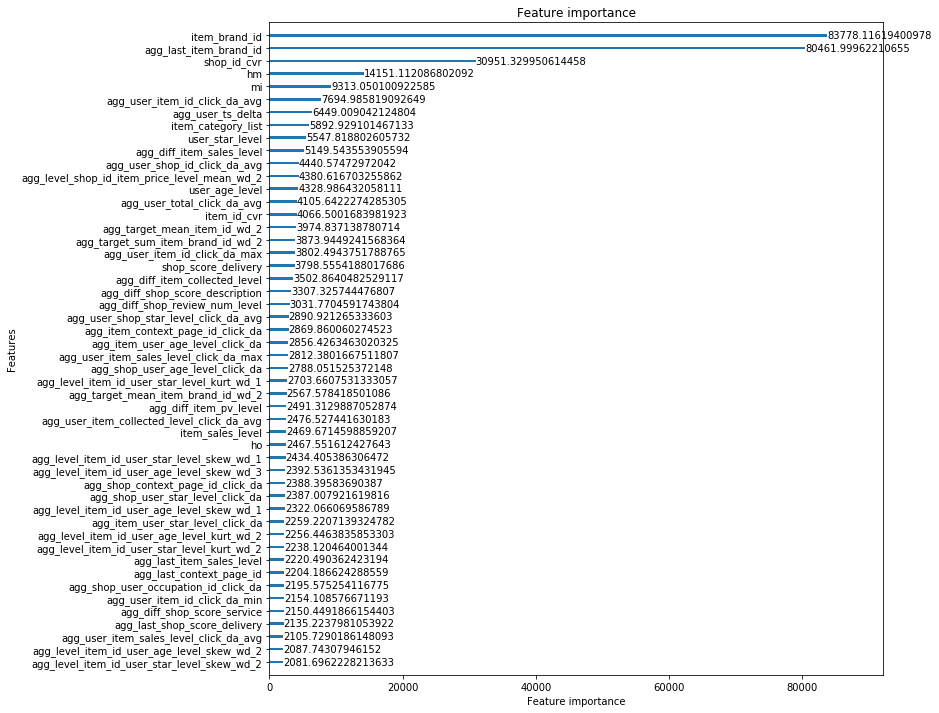

In [11]:
lgb1 = fit_lgb(X_tr, y_tr, X_va, y_va, cates_cols)

In [12]:
lgb1.best_score

defaultdict(dict,
            {'train': {'binary_logloss': 0.06461547750789247},
             'valid': {'binary_logloss': 0.08173286810722055}})

In [13]:
y_hat_lgb1 = lgb1.predict(X_te, num_iteration=lgb1.best_iteration)

['item_category_list', 'item_city_id', 'user_gender_id', 'item_brand_id', 'agg_last_item_brand_id']
Training until validation scores don't improve for 125 rounds.
[50]	train's binary_logloss: 0.385343	valid's binary_logloss: 0.384034
[100]	train's binary_logloss: 0.241873	valid's binary_logloss: 0.239989
[150]	train's binary_logloss: 0.167292	valid's binary_logloss: 0.165397
[200]	train's binary_logloss: 0.126695	valid's binary_logloss: 0.125422
[250]	train's binary_logloss: 0.103963	valid's binary_logloss: 0.103953
[300]	train's binary_logloss: 0.0906703	valid's binary_logloss: 0.0926399
[350]	train's binary_logloss: 0.0824288	valid's binary_logloss: 0.0868358
[400]	train's binary_logloss: 0.0768443	valid's binary_logloss: 0.0839826
[450]	train's binary_logloss: 0.0727461	valid's binary_logloss: 0.0826639
[500]	train's binary_logloss: 0.0693097	valid's binary_logloss: 0.0820472
[550]	train's binary_logloss: 0.0663999	valid's binary_logloss: 0.0818174
[600]	train's binary_logloss: 0.06

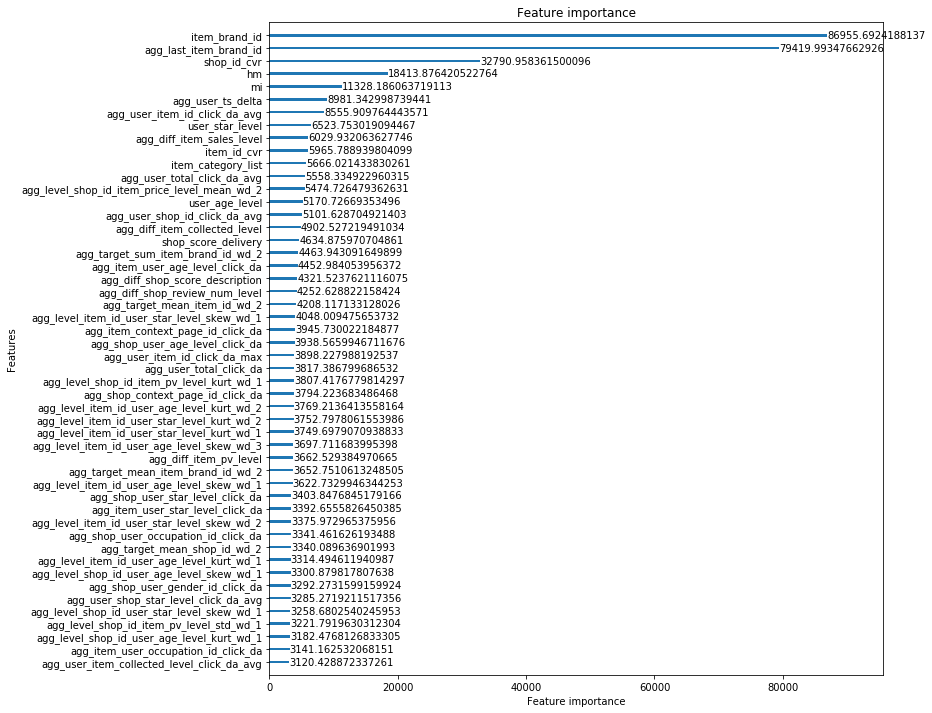

In [14]:
unimportant_features = []
for x in sorted(zip(lgb1.feature_name(), lgb1.feature_importance("gain")), key=lambda x: x[1]):
    if x[1] < 1000:
        unimportant_features.append(x[0])

X_tr.drop(unimportant_features, axis=1, inplace=True)
X_va.drop(unimportant_features, axis=1, inplace=True)
X_te.drop(unimportant_features, axis=1, inplace=True)
cates_cols = list(filter(lambda x : x in X_tr.columns.values.tolist(), cates_cols))
print(cates_cols)
lgb2 = fit_lgb(X_tr, y_tr, X_va, y_va, cates_cols)

In [15]:
lgb2.best_score

defaultdict(dict,
            {'train': {'binary_logloss': 0.06524416032552532},
             'valid': {'binary_logloss': 0.08180931649979394}})

In [16]:
y_hat_lgb2 = lgb2.predict(X_te, num_iteration=lgb2.best_iteration)

## catboost

In [17]:
X_tr, y_tr, X_va, y_va, X_te =  get_dataset(False)

(521026, 66)
Found ./cache/final_dataset_tr_19_23.h5
Found ./cache/final_dataset_te_24.h5


In [18]:
cates_cols = [
    'item_category_list', 'item_city_id', 'user_gender_id',
    'user_occupation_id', 'item_brand_id'
]

cates_cols = cates_cols +  list(filter(lambda x : 'user' not in x, ['agg_last_'+ c for c in cates_cols]))

cates_cols

['item_category_list',
 'item_city_id',
 'user_gender_id',
 'user_occupation_id',
 'item_brand_id',
 'agg_last_item_category_list',
 'agg_last_item_city_id',
 'agg_last_item_brand_id']

In [19]:
X_tr[cates_cols] = X_tr[cates_cols].astype(int)
X_va[cates_cols] = X_va[cates_cols].astype(int)
X_te[cates_cols] = X_te[cates_cols].astype(int)

In [20]:
cates_idx = [X_tr.columns.values.tolist().index(c) for c in cates_cols]

Fitting CatBoostClassifier ...
0:	learn: 0.6540493	test: 0.6536837	best: 0.6536837 (0)	total: 2.43s	remaining: 1h 21m
50:	learn: 0.1181715	test: 0.1131844	best: 0.1131844 (50)	total: 2m 39s	remaining: 1h 41m 17s
100:	learn: 0.0907590	test: 0.0851852	best: 0.0851852 (100)	total: 4m 58s	remaining: 1h 33m 34s
150:	learn: 0.0874808	test: 0.0819363	best: 0.0819363 (150)	total: 7m 28s	remaining: 1h 31m 31s
200:	learn: 0.0865898	test: 0.0812004	best: 0.0812004 (200)	total: 9m 45s	remaining: 1h 27m 21s
250:	learn: 0.0861327	test: 0.0809416	best: 0.0809416 (250)	total: 12m 16s	remaining: 1h 25m 30s
300:	learn: 0.0858528	test: 0.0808221	best: 0.0808221 (300)	total: 14m 34s	remaining: 1h 22m 15s
350:	learn: 0.0856318	test: 0.0807420	best: 0.0807417 (349)	total: 17m 27s	remaining: 1h 22m 2s
400:	learn: 0.0854065	test: 0.0806692	best: 0.0806692 (400)	total: 20m 24s	remaining: 1h 21m 24s
450:	learn: 0.0852125	test: 0.0806135	best: 0.0806132 (447)	total: 22m 22s	remaining: 1h 16m 50s
500:	learn: 0.08

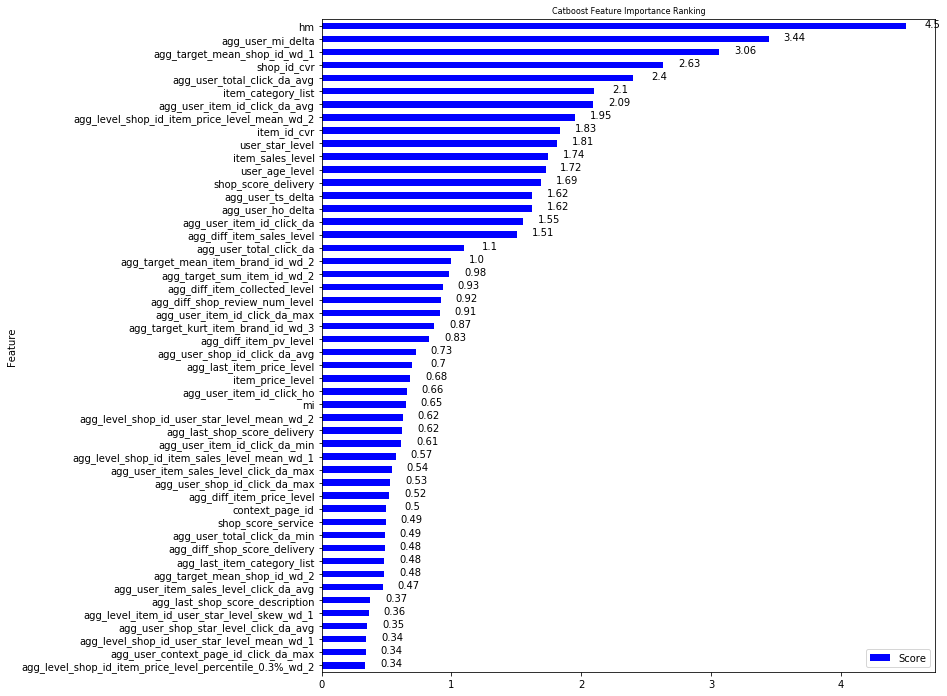

In [21]:
cat1 = fit_cat(X_tr, y_tr, X_va, y_va, cates_idx)

In [22]:
y_hat_cat1 = cat1.predict_proba(X_te)[:,1]

In [23]:
for score, name in sorted(zip(cat1.feature_importances_ , X_tr.columns), reverse=True):
    if score <= 0.1:
        del X_tr[name]
        del X_va[name]
        del X_te[name]
        print('{}: {}'.format(name, score))

agg_level_shop_id_item_collected_level_kurt_wd_1: 0.09986381353915857
agg_shop_item_sales_level_click_ho: 0.09983369183938413
agg_shop_item_category_list_click_ho: 0.09927974383054766
agg_item_user_age_level_click_da_min: 0.09883666570405214
agg_target_kurt_item_brand_id_wd_1: 0.09830238037153484
agg_item_user_id_click_da_avg: 0.09804258427497563
agg_level_shop_id_item_collected_level_skew_wd_3: 0.0971453563579179
agg_level_user_id_item_pv_level_mad_wd_2: 0.09686802508031692
agg_level_shop_id_item_collected_level_mean_wd_2: 0.09671636382904876
agg_level_shop_id_user_age_level_sem_wd_1: 0.09667437212224239
agg_level_item_id_user_star_level_kurt_wd_1: 0.09549967497255246
agg_shop_item_price_level_click_da: 0.09502615424947611
agg_level_user_id_item_sales_level_mean_wd_3: 0.09482055329988057
agg_user_shop_id_click_da_min: 0.09460896258721688
agg_shop_context_page_id_click_ho: 0.0942652247248297
agg_shop_user_gender_id_click_da: 0.09382486527223409
agg_level_shop_id_user_star_level_kurt_wd

agg_level_user_id_item_sales_level_skew_wd_3: 0.05605863458668464
agg_target_count_item_id_wd_1: 0.055627174367772814
agg_target_mean_item_id_wd_1: 0.054988613406786624
agg_user_shop_review_num_level_click_da_min: 0.0548665507417092
agg_level_shop_id_user_star_level_percentile_0.9%_wd_3: 0.0547313557222435
agg_level_user_id_item_sales_level_mad_wd_2: 0.054711222962508695
agg_level_item_id_user_age_level_std_wd_2: 0.054298237964282056
agg_level_shop_id_item_price_level_freq_wd_1: 0.05427714514191516
agg_target_sem_item_city_id_wd_3: 0.05419724235404033
agg_user_item_brand_id_click_ho: 0.05409278367583053
agg_user_context_page_id_click_da: 0.054006849664929246
item_collected_level: 0.05357409859554367
agg_item_user_occupation_id_click_da_min: 0.053568226905784194
agg_level_user_id_item_collected_level_percentile_0.9%_wd_3: 0.05255611536125504
agg_level_shop_id_item_sales_level_kurt_wd_1: 0.05224592978100991
agg_item_user_occupation_id_click_da_max: 0.0520041207094273
agg_level_user_id_it

agg_item_brand_id_sum_count: 0.031806741008761706
agg_level_user_id_item_sales_level_percentile_0.9%_wd_1: 0.031606939953910486
agg_level_user_id_item_sales_level_kurt_wd_2: 0.03153612576066023
agg_target_count_item_city_id_wd_2: 0.03147192530209308
agg_level_user_id_item_collected_level_std_wd_2: 0.03136046496451421
agg_level_user_id_shop_review_num_level_kurt_wd_2: 0.03123270858261232
agg_user_item_collected_level_click_da: 0.031065856457802132
agg_shop_item_brand_id_click_ho: 0.030983719246380687
agg_target_sem_shop_id_wd_1: 0.030835665796564635
agg_level_item_id_user_age_level_freq_wd_2: 0.030826315838741708
agg_level_user_id_shop_review_num_level_skew_wd_1: 0.03034268255071272
agg_level_shop_id_item_collected_level_std_wd_1: 0.03014275143045448
agg_shop_item_pv_level_click_da: 0.030105619389036775
agg_level_user_id_shop_review_num_level_kurt_wd_1: 0.029891897801194136
agg_level_shop_id_item_sales_level_freq_wd_3: 0.02986941289228142
agg_shop_item_collected_level_click_da_max: 0.02

agg_level_user_id_item_price_level_mad_wd_3: 0.015204851514745505
agg_level_shop_id_item_pv_level_std_wd_2: 0.0151258194516893
agg_shop_item_price_level_click_da_avg: 0.014895046530908744
agg_level_user_id_item_price_level_percentile_0.9%_wd_1: 0.014537851192993745
agg_level_user_id_shop_star_level_percentile_0.9%_wd_2: 0.014364660069886808
agg_level_user_id_item_collected_level_mad_wd_1: 0.014342059569979101
agg_shop_item_collected_level_click_da_min: 0.014277821479282202
agg_target_count_user_id_wd_3: 0.014261356621490364
agg_shop_user_occupation_id_click_da_max: 0.014057696596406726
agg_shop_item_sales_level_click_da_min: 0.013951919025943454
agg_level_item_id_user_star_level_percentile_0.3%_wd_1: 0.01383686650778634
agg_last_item_city_id: 0.013796617230123237
agg_level_user_id_item_sales_level_percentile_0.3%_wd_3: 0.013701497618094156
agg_level_user_id_item_collected_level_percentile_0.3%_wd_2: 0.013669779165091182
agg_target_sum_shop_id_wd_1: 0.01353868749914629
agg_level_shop_id

agg_item_shop_star_level_click_da_min: 0.0
agg_item_shop_star_level_click_da_max: 0.0
agg_item_shop_star_level_click_da_avg: 0.0
agg_item_shop_star_level_click_da: 0.0
agg_item_shop_review_num_level_click_ho: 0.0
agg_item_shop_review_num_level_click_da_min: 0.0
agg_item_shop_review_num_level_click_da_max: 0.0
agg_item_shop_review_num_level_click_da_avg: 0.0
agg_item_shop_review_num_level_click_da: 0.0
agg_item_shop_id_click_da_min: 0.0
agg_item_shop_id_click_da_max: 0.0
agg_item_shop_id_click_da_avg: 0.0
agg_item_shop_id_click_da: 0.0


In [24]:
X_tr.shape,X_va.shape,X_te.shape

((271518, 175), (57421, 175), (42888, 175))

In [25]:
best_cat_params = cat1.get_params().copy()
best_cat_params.update({'use_best_model': True})

In [26]:
import catboost as cb

In [27]:
cat2 = cb.CatBoostClassifier(**best_cat_params)
cat2 = cat2.fit(X_tr, y_tr, eval_set=(X_va, y_va))

0:	learn: 0.6541551	test: 0.6538943	best: 0.6538943 (0)	total: 556ms	remaining: 18m 31s
50:	learn: 0.1177829	test: 0.1105322	best: 0.1105322 (50)	total: 24.8s	remaining: 15m 47s
100:	learn: 0.0902868	test: 0.0844505	best: 0.0844505 (100)	total: 49.1s	remaining: 15m 24s
150:	learn: 0.0869372	test: 0.0817048	best: 0.0817048 (150)	total: 1m 13s	remaining: 14m 58s
200:	learn: 0.0861022	test: 0.0811970	best: 0.0811970 (200)	total: 1m 37s	remaining: 14m 34s
250:	learn: 0.0856084	test: 0.0810185	best: 0.0810185 (250)	total: 2m 1s	remaining: 14m 4s
300:	learn: 0.0852236	test: 0.0808762	best: 0.0808761 (299)	total: 2m 24s	remaining: 13m 36s
350:	learn: 0.0849057	test: 0.0807743	best: 0.0807743 (350)	total: 2m 49s	remaining: 13m 16s
400:	learn: 0.0846392	test: 0.0807198	best: 0.0807175 (394)	total: 3m 19s	remaining: 13m 14s
450:	learn: 0.0843621	test: 0.0806597	best: 0.0806597 (450)	total: 3m 42s	remaining: 12m 45s
500:	learn: 0.0841562	test: 0.0806371	best: 0.0806331 (496)	total: 4m 6s	remainin

********************************************************************************
*******************************Feature Importance*******************************
................................................................................
.                                                hm =>   5.39001
.                                       shop_id_cvr =>   5.06182
.                             agg_user_id_sum_count =>   3.54272
.                                 agg_user_mi_delta =>   2.95127
.                                 agg_user_ts_delta =>   2.37962
.                                    user_age_level =>   2.22732
.                                   user_star_level =>   2.19393
.                                  item_sales_level =>   1.99975
.                                       item_id_cvr =>   1.92691
.      agg_level_shop_id_item_price_level_mean_wd_2 =>   1.84659
.                         agg_diff_item_sales_level =>   1.67226
.                     agg_user_item_id_cli

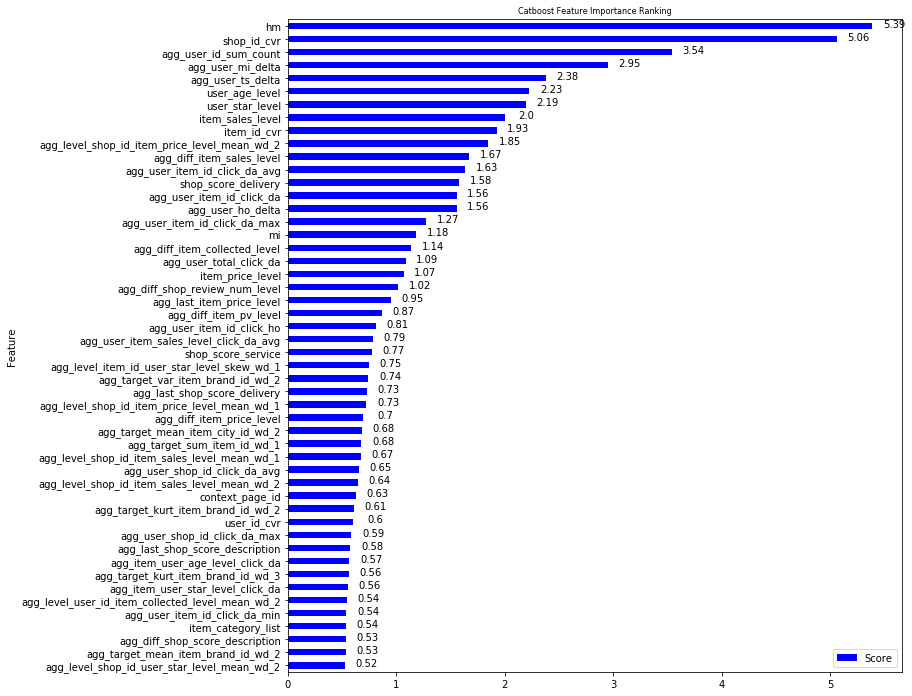

In [28]:
verbose_feature_importance_cat(cat2, X_tr)

In [29]:
y_hat_cat2 = cat2.predict_proba(X_te)[:,1]

In [30]:
for score, name in sorted(zip(cat2.feature_importances_, X_tr.columns), reverse=True):
    if score <= 0.1:
        del X_tr[name]
        del X_va[name]
        del X_te[name]
        print('{}: {}'.format(name, score))
print(X_tr.shape, X_va.shape, X_te.shape)

agg_user_item_category_list_click_ho: 0.09873215255243692
agg_user_context_page_id_click_da_max: 0.09200967624554632
agg_target_mean_item_brand_id_wd_1: 0.07648274262005904
agg_user_item_category_list_click_da_max: 0.06945593013919783
agg_user_item_price_level_click_ho: 0.06702626191523821
(271518, 170) (57421, 170) (42888, 170)


In [31]:
cat3 = cb.CatBoostClassifier(**best_cat_params)
cat3 = cat3.fit(X_tr, y_tr, eval_set=(X_va, y_va))

0:	learn: 0.6538226	test: 0.6533162	best: 0.6533162 (0)	total: 899ms	remaining: 29m 57s
50:	learn: 0.1175230	test: 0.1104851	best: 0.1104851 (50)	total: 35.3s	remaining: 22m 27s
100:	learn: 0.0904128	test: 0.0845468	best: 0.0845468 (100)	total: 1m	remaining: 18m 56s
150:	learn: 0.0871362	test: 0.0817953	best: 0.0817953 (150)	total: 1m 23s	remaining: 17m 8s
200:	learn: 0.0861955	test: 0.0812244	best: 0.0812244 (200)	total: 1m 47s	remaining: 16m 2s
250:	learn: 0.0857129	test: 0.0810104	best: 0.0810104 (250)	total: 2m 10s	remaining: 15m 12s
300:	learn: 0.0853580	test: 0.0808924	best: 0.0808907 (299)	total: 2m 34s	remaining: 14m 29s
350:	learn: 0.0850391	test: 0.0808030	best: 0.0808026 (349)	total: 2m 57s	remaining: 13m 52s
400:	learn: 0.0847317	test: 0.0807268	best: 0.0807268 (400)	total: 3m 20s	remaining: 13m 17s
450:	learn: 0.0844928	test: 0.0806678	best: 0.0806678 (450)	total: 3m 43s	remaining: 12m 45s
500:	learn: 0.0842652	test: 0.0806379	best: 0.0806371 (499)	total: 4m 5s	remaining: 

In [32]:
y_hat_cat3 = cat3.predict_proba(X_te)[:,1]

********************************************************************************
*******************************Feature Importance*******************************
................................................................................
.                                                hm =>   5.17445
.                             agg_user_id_sum_count =>   3.71499
.                      agg_target_mean_shop_id_wd_3 =>   3.23190
.                                 agg_user_mi_delta =>   2.66829
.                                       shop_id_cvr =>   2.40292
.                                 agg_user_ho_delta =>   2.31030
.                                   user_star_level =>   2.20475
.                                    user_age_level =>   2.18713
.      agg_level_shop_id_item_price_level_mean_wd_2 =>   2.06240
.                               shop_score_delivery =>   1.96933
.                                  item_sales_level =>   1.96549
.                                 agg_user

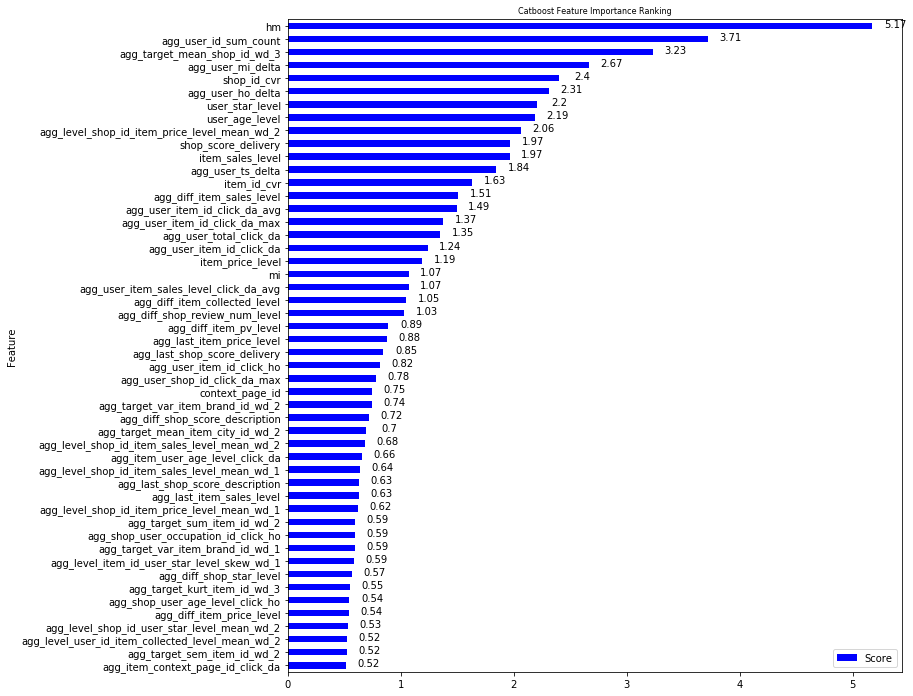

In [33]:
verbose_feature_importance_cat(cat3, X_tr)

In [35]:
dfal = get_nominal_dfal()
hat = dfal.loc[dfal.da==24, ['instance_id']]
del dfal
gc.collect()

24655

In [36]:
hat.shape, y_hat_cat1.shape

((42888, 1), (42888,))

In [37]:
hat['lgb1'] = y_hat_lgb1
hat['lgb2'] = y_hat_lgb2
hat['cat1'] = y_hat_cat1
hat['cat2'] = y_hat_cat2
hat['cat3'] = y_hat_cat3

In [38]:
hat = hat.set_index('instance_id')
hat.head()

,lgb1,lgb2,cat1,cat2,cat3
instance_id,,,,,
55144604125888,0.121247,0.118986,0.087372,0.091499,0.112639
221669167755726,0.016916,0.016606,0.014771,0.011881,0.011267
566644865989395,0.016826,0.015193,0.011045,0.009511,0.009393
954943998950521,0.033891,0.038507,0.088088,0.096400,0.115101
1192015136416062,0.028153,0.027257,0.017520,0.020519,0.018625


In [39]:
hat['predicted_score'] = hat['cat1'] #hat.mean(axis=1)

In [40]:
hat.head()

,lgb1,lgb2,cat1,cat2,cat3,predicted_score
instance_id,,,,,,
55144604125888,0.121247,0.118986,0.087372,0.091499,0.112639,0.087372
221669167755726,0.016916,0.016606,0.014771,0.011881,0.011267,0.014771
566644865989395,0.016826,0.015193,0.011045,0.009511,0.009393,0.011045
954943998950521,0.033891,0.038507,0.088088,0.096400,0.115101,0.088088
1192015136416062,0.028153,0.027257,0.017520,0.020519,0.018625,0.017520


In [41]:
from time import time

In [42]:
hat.to_csv(
    './rests/20180422-lgb-cat-{}.txt'.format(int(time() // 1)),
    index=True,
    header=True,
    sep=' ',
    columns=['predicted_score'])

In [ ]:
!head ./rests/20180422-lgb-cat.txt